# Prompt Classification

In [1]:
import sys
import os
import copy
import pandas as pd

from tqdm import tqdm

import torch
from torch.amp import autocast, GradScaler  # instead ocf cuda.amp, using .amp for mixed precision training. 
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import ticker

In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("Using NVIDIA GPU (CUDA)")
elif torch.backends.mps.is_available():
  device = torch.device("mps")
  print("Using Apple Silicon GPU (MPS)")
else:
  device = torch.device("cpu")
  print("Using CPU")

print("Selected device:", device)

⚙️ Using CPU
Selected device: cpu


In [3]:
# load / train test datasets
# Get the directory where this script is located
project_dir = os.getcwd()
train_file_path = os.path.join(project_dir, "datasets", "train_dataset.csv")
test_file_path = os.path.join(project_dir, "datasets", "test_dataset.csv")

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Print dataset samples for verification
print("Train Dataset Sample:")
display(train_df.head())

print("Test Dataset Sample:")
display(test_df.head())

Train Dataset Sample:


,prompt,class
0,Homer simpson playing ping pong with a sloth w...,image
1,"A donut being licked by a lizard in a winery, ...",image
2,A jug of milk and a donut sitting next to a wo...,image
3,Winnie the pooh playing blackjack and losing i...,image
4,A cup of tea and a pizza made out of plastic i...,image


Test Dataset Sample:


,prompt,class
0,"Digital Art With advancements in technology, c...",image
1,"Fantasy Art With advancements in technology, t...",image
2,"Abstract Art With advancements in technology, ...",image
3,"Digital Art With advancements in technology, m...",image
4,"Fantasy Art With advancements in technology, t...",image


Index(['text', 'image'], dtype='object', name='class')


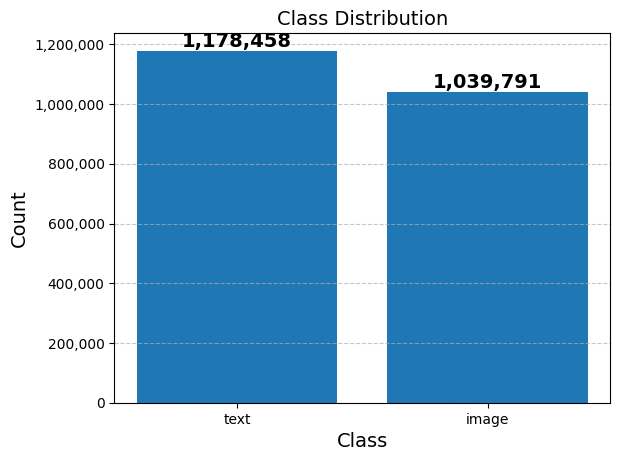

In [4]:
# Class counts
value_counts = train_df['class'].value_counts()
labels = value_counts.index
counts = value_counts.values
print(labels)

# Create the bar chart
#plt.figure(figsize=(8, 6))
bars = plt.bar(labels, counts)

# Add comma-separated labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:,}', ha='center', va='bottom', fontweight='bold', fontsize=14)

plt.title('Class Distribution', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.tight_layout()
#plt.show()

In [5]:
# Encode labels (1 for Text, 0 for Image)
label2id = {"image": 0, "text": 1}
id2label = {0: "image", 1: "text"}

# Standardize and map labels
train_df['label'] = train_df['class'].str.lower().map(label2id)
test_df['label'] = test_df['class'].str.lower().map(label2id)

X = train_df['prompt']
y = train_df['label']

# Split into train and validation sets (stratified)
X_train, X_val, y_train, y_val = train_test_split(
  X, y, test_size=0.15, random_state=20, stratify=y
)

X_test = test_df['prompt']
y_test = test_df['label']


print("Train classes:", train_df['class'].unique())
print("Test classes:", test_df['class'].unique())
#print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

Train classes: ['image' 'text']
Test classes: ['image' 'text']


In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load pretrained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("roberta-large")

''' load pretrained or existing model'''
#load pretrained model
model = AutoModelForSequenceClassification.from_pretrained(
  "roberta-large", 
  num_labels=2, 
  id2label=id2label,
  label2id=label2id
).to(device)
'''
#load existing model
model_path = "models/roBERTa-Large_best_model_w_tuning_4_14_25"  # update if needed
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
'''

#model = torch.jit.script(model)  # Convert model to TorchScript for optimization

model.gradient_checkpointing_enable()  # Saves VRAM

# Optimizes performance when cuda
if device.type == "cuda":
  torch.backends.cudnn.benchmark = True

print('done')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


done


In [7]:
# setting earlystopping class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=1e-3, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.best_model = None
        self.best_loss = float('inf')
        self.counter = 0
        self.status = ""
        self.restore_best_weights = restore_best_weights
    
    def __call__(self, model, val_loss):
      if val_loss < self.best_loss - self.min_delta:
        self.best_loss = val_loss
        self.best_model = copy.deepcopy(model.state_dict())
        self.counter = 0
        self.status = f"Improvement found, counter reset to {self.counter}"
      else:
        self.counter += 1
        self.status = f"No improvement in the last {self.counter} epochs"
        if self.counter >= self.patience:
          self.status = f"Early stopping triggered after {self.counter} epochs"
          if self.restore_best_weights and self.best_model is not None:
            model.load_state_dict(self.best_model)
          return True
        return False
print('done')

done


In [8]:
# convert datasets to dataset class
from dataset_utils import PromptDataset
#val temporarily removed

train_dataset = PromptDataset(X_train, y_train, tokenizer=tokenizer)

validation_dataset = PromptDataset(X_val, y_val, tokenizer=tokenizer)


test_dataset = PromptDataset(X_test, y_test, tokenizer=tokenizer)
print("test dataset conversions completed \n")


test dataset conversions completed 



In [9]:
pin_memory = True if device.type == "cuda" else False

cpu_count = os.cpu_count()
if device.type == "cuda":
  numWorkers = min(12, cpu_count - 2)
elif device.type == "mps":
  numWorkers = 0
else:
  numWorkers = min(8, cpu_count // 2)

print(f"Device: {device}")
print(f"num_workers: {numWorkers}, pin_memory: {pin_memory}")

Device: cpu
num_workers: 8, pin_memory: False


In [10]:
batchSize= 64

train_loader = DataLoader(
    train_dataset, 
    batch_size=batchSize, 
    shuffle=True, 
    num_workers=numWorkers, 
    pin_memory=pin_memory
)

val_loader = DataLoader(
  validation_dataset,
  batch_size=batchSize,
  num_workers=numWorkers,
  pin_memory=pin_memory
)

test_loader = DataLoader(
  test_dataset,
  batch_size=batchSize,
  num_workers=numWorkers,
  pin_memory=pin_memory
)
print("Dataloader completed")

epochs = 5  # number of epochs
done = False
es = EarlyStopping()
epoch = 0
lr = 1e-5 # iterations 1e-6, 4e-6, 5e-5 (patience: 3, min_delta: 1e-3)
print('done')

Dataloader completed
done


In [11]:
from transformers import get_scheduler

optimizer = torch.optim.AdamW(
  model.parameters(), 
  lr=lr)  # try to decrease

num_training_steps = len(train_loader) * epochs  # compute total training steps


# Define learning rate scheduler
lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=int(0.1 * num_training_steps),  # 10% warmup
  num_training_steps=num_training_steps
)
    
# Use weighted CrossEntropyLoss
criterion = torch.nn.CrossEntropyLoss()

# Initialize the GradScaler for mixed precision training
if device.type == "cuda":
  scaler = torch.amp.GradScaler()
  torch.cuda.memory_summary(device=None, abbreviated=False)
  
non_blocking = device.type == "cuda"

print('done')

done


In [12]:
save_path = "./models/roBERTa-Large_classification_model_04_30_25_TESTING"

In [13]:
def train():
    train_losses = []
    #val_losses = []
    done = False
    
    for epoch in tqdm(range(epochs), desc="Epochs", unit="epoch", position=0):
        if done:
            break
        total_loss = 0
        model.train()
        
        # INNER TRAIN LOOP
        for batch in tqdm(train_loader, desc=f"Train {epoch+1}", unit="batch", leave=True, position=0):
            input_ids = batch['input_ids'].to(device, non_blocking=non_blocking)
            attention_mask = batch['attention_mask'].to(device, non_blocking=non_blocking)
            labels = batch['label'].to(device, non_blocking=non_blocking)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
            lr_scheduler.step()
        
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"\nEpoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}")
        '''
        # VALIDATION LOOP
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Val {epoch+1}", unit="batch", leave=True, position=0):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
            
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Val Loss: {avg_val_loss:.4f}")
        
        if es(model, avg_val_loss):
          done = True
        '''
    print("Training complete")
    
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    print(f"Model saved to {save_path}")
    if device == "cuda":
        torch.cuda.empty_cache()
    '''
    # Save losses to CSV
    loss_df = pd.DataFrame({
    'epoch': list(range(1, len(train_losses) + 1)),
    'train_loss': train_losses,
    'val_loss': val_losses
    })
    '''
    loss_df = pd.DataFrame({
    'epoch': list(range(1, len(train_losses) + 1)),
    'train_loss': train_losses,
    })
    loss_df.to_csv("results/loss_history_04_17_25.csv", index=False)
    print("Loss history saved to loss_history_04_17_25.csv")

In [ ]:
torch.cuda.empty_cache()
train() 

Train 1:   0%|                                                                            | 0/29462 [00:00<?, ?batch/s]

In [ ]:
if(os.path.exists("results/loss_history_04_17_25.csv")):
  loss_df = pd.read_csv("results/loss_history_04_17_25.csv")

  # Optional: extract as lists if needed
  train_losses = loss_df['train_loss'].tolist()
  val_losses = loss_df['val_loss'].tolist()

  print("Loaded loss history from loss_history.csv")

  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.legend()
  plt.title("Training & Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.savefig("loss_plot_04_17_25.png")

In [ ]:
# Load the saved model
if(os.path.exists(save_path)):
  del model  # Clear memory
  model = AutoModelForSequenceClassification.from_pretrained(save_path).to(device)
  tokenizer = AutoTokenizer.from_pretrained(save_path)
  print("Model loaded successfully.")



In [ ]:
test_path = "results/predictions_04_17_25.csv"
import torch.nn.functional as F
def test():
  # Evaluate trained model
  model.eval()
  y_pred, y_true = [], []
  with torch.no_grad():
    for batch in tqdm(test_loader, desc="evaluating", unit="batch"):
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids, attention_mask=attention_mask)
      preds = torch.argmax(F.softmax(outputs.logits.float(), dim=-1), dim=1)
      y_pred.extend(preds.cpu().numpy())
      y_true.extend(labels.cpu().numpy())
  df_test = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
  df_test.to_csv(test_path, index=False)
  print("Predictions saved to predictions.csv")

#if(not os.path.exists(test_path)):
test()

In [ ]:
import seaborn as sns
if(os.path.exists(test_path)):
  pred_df = pd.read_csv(test_path)
  y_true = pred_df['y_true'].values
  y_pred = pred_df['y_pred'].values
  print("Loaded predictions from predictions_04_17_25.csv")

  # Metrics
  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  cm = confusion_matrix(y_true, y_pred)

  print(f"Accuracy: {accuracy * 100:.2f}%")
  print(f"F1 Score: {f1:.2f}")
  print("Confusion Matrix:")
  heatmap = sns.heatmap(cm, annot=True, fmt='d')
  plt.xlabel('Predicted')
  plt.ylabel('Truth')
  # Save the figure
  figure = heatmap.get_figure()
  figure.savefig('confusion_matrix_04_17_25.png', bbox_inches='tight')
